In [345]:
import numpy as np
from scipy.optimize import dual_annealing
import pulp
import pandas as pd
import os
import random
from wmape import WMAPE
from order_generator import OrderGenerator
from order_merger import OrderMerger
import math
import matplotlib.pyplot as plt

In [346]:
random.seed(42)

In [347]:
def objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day):
    # Apply the current allocation to the orders dataframe
    orders_df['site'] = current_allocation

    # Aggregate the orders for the initial and target lead days
    aggregated_initial_df = OrderMerger.aggregate_items(orders_df, initial_day)
    aggregated_target_df = OrderMerger.aggregate_items(target_orders_df, target_day)

    # Merge the aggregated dataframes
    merged_df = OrderMerger.merge_allocation(aggregated_initial_df, aggregated_target_df, initial_day, target_day)

    # Calculate WMAPE
    _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{target_day}', f'lead_{initial_day}')
    return wmape_site

In [348]:
def generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict, steps=3):
    new_allocation = current_allocation.copy()

    for _ in range(steps):
        max_attempts = 100

        unique_order_ids = orders_df['order_id'].unique()

        for _ in range(max_attempts):
            order_indices = random.sample(range(len(unique_order_ids)), 2)

            order_id1 = unique_order_ids[order_indices[0]]
            order_id2 = unique_order_ids[order_indices[1]]

            items1 = orders_df[orders_df['order_id'] == order_id1]['item_id'].tolist()
            items2 = orders_df[orders_df['order_id'] == order_id2]['item_id'].tolist()

            site1 = new_allocation[orders_df[orders_df['order_id'] == order_id1].index[0]]
            site2 = new_allocation[orders_df[orders_df['order_id'] == order_id2].index[0]]

            if all(item in eligibility_dict[site2] for item in items1) and all(item in eligibility_dict[site1] for item in items2):
                new_allocation[orders_df[orders_df['order_id'] == order_id1].index] = site2
                new_allocation[orders_df[orders_df['order_id'] == order_id2].index] = site1
                break

    return new_allocation

In [349]:
def adaptive_cooling_schedule(temp, alpha, improvement_rate):
    if improvement_rate > 0.01:
        alpha = min(alpha * 1.01, 0.99)  # Slightly increase alpha but cap it to 0.99
    elif improvement_rate < 0.001:
        alpha = max(alpha * 0.99, 0.90)  # Slightly decrease alpha but ensure it doesn't drop too low
    return temp * alpha


def acceptance_probability(current_energy, new_energy, temperature):
    if new_energy < current_energy:
        return 1.0
    else:
        return math.exp((current_energy - new_energy) / temperature)


def simulated_annealing(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, initial_temp, final_temp, alpha, max_iter):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    temp = initial_temp
    step = 0

    while temp > final_temp and step < max_iter:
        new_allocation = generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict)
        new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        improvement_rate = (current_energy - best_energy) / current_energy
        temp = adaptive_cooling_schedule(temp, alpha, improvement_rate)
        step += 1

        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}, Temperature: {temp}')

    print(f'Final Step: {step}, Final Temperature: {temp}')
    return best_allocation, best_energy


In [350]:
allocation_dir = 'allocations'
merged_dir = 'merged'
sa_allocation_dir = 'sa_allocations'
sa_merged_dir = 'sa_merged'

# Create the merged directory if it doesn't exist
os.makedirs(sa_allocation_dir, exist_ok=True)
os.makedirs(sa_merged_dir, exist_ok=True)

In [351]:
def perform_simulated_annealing(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict):
    # Load the initial allocation dataframe for the first lead day
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    
    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{lead_days[0]}.csv', index=False)
    
    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i-1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')

        best_allocation, best_energy = simulated_annealing(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, initial_temp, final_temp, alpha, max_iter)
        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation
        
        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv', index=False)
        
        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()

In [352]:
def perform_simulated_annealing_consecutive_days(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict):
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')
    previous_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{lead_days[0]}.csv', index=False)
    
    best_energies = []
    
    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i-1]
        
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')
        
        if i == 1:
            best_allocation, best_energy = simulated_annealing(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, initial_temp, final_temp, alpha, max_iter)
        else:
            best_allocation, best_energy = simulated_annealing_with_constraint(current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day, initial_temp, final_temp, alpha, max_iter, best_energies[-1])
        
        best_energies.append(best_energy)
        current_df['site'] = best_allocation
        current_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv', index=False)
        
        previous_df = current_df.copy()

def simulated_annealing_with_constraint(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, initial_temp, final_temp, alpha, max_iter, previous_best_energy):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    temp = initial_temp
    step = 0

    while best_energy > previous_best_energy and step < max_iter:
        new_allocation = generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict)
        new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        improvement_rate = (current_energy - best_energy) / current_energy
        temp = adaptive_cooling_schedule(temp, alpha, improvement_rate)
        step += 1

        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}, Temperature: {temp}')

    if best_energy <= previous_best_energy:
        print(f'Successfully reduced WMAPE for lead days {initial_day} to {target_day}')
        return best_allocation, best_energy

    # Perform regular simulated annealing if WMAPE is already lower
    while temp > final_temp and step < max_iter:
        new_allocation = generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict)
        new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        improvement_rate = (current_energy - best_energy) / current_energy
        temp = adaptive_cooling_schedule(temp, alpha, improvement_rate)
        step += 1

        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}, Temperature: {temp}')

    print(f'Final Step: {step}, Final Temperature: {temp}')
    return best_allocation, best_energy




In [353]:
def calculate_wmape_for_all_days(lead_days):
    wmape_site_values = []
    wmape_global_values = []

    final_day = lead_days[-1]
    final_day_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{final_day}.csv')
    aggregated_final_day = OrderMerger.aggregate_items(final_day_df, final_day)
    
    for day in lead_days[:-1]:
        current_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{day}.csv')
        aggregated_current_day = OrderMerger.aggregate_items(current_df, day)
        
        merged_df = OrderMerger.merge_allocation(aggregated_current_day, aggregated_final_day, day, final_day)
        
        site_df, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{day}', f'lead_{final_day}')
        global_df, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{day}', f'lead_{final_day}')
        
        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)
        
        # Save the merged dataframe
        merged_df.to_csv(f'{sa_merged_dir}/sa_merged_lead_day_{day}_to_{final_day}.csv', index=False)
    
    # Add 0 for lead day 0
    wmape_site_values.append(0)
    wmape_global_values.append(0)
    
    return wmape_site_values, wmape_global_values

In [354]:
def plot_wmape(lead_days, wmape_site_values, wmape_global_values):
    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(lead_days, wmape_site_values, linestyle='-', color='b', label='WMAPE Site')
    ax.plot(lead_days, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')

    # Add labels and title
    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Different Lead Days - Simulated Annealing')
    ax.set_xticks(lead_days)
    ax.legend()

    # Invert x-axis to have 0 at the end
    ax.invert_xaxis()

    plt.show()


In [282]:

lead_days = list(range(18, -1, -1))  # Define the lead days from 18 to 0
initial_temp = 5230
final_temp = 0.1
alpha = 0.99
max_iter = 10000

eligibility_dict = OrderGenerator.load_eligibility_dict('eligibility_dict.json')

# Perform simulated annealing for consecutive lead days
perform_simulated_annealing_consecutive_days(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict)


Step 100: Best Energy 0.39260077305356156, Temperature: 1895.2056534104
Step 200: Best Energy 0.39260077305356156, Temperature: 673.1027838988975
Step 300: Best Energy 0.390944229707344, Temperature: 227.34342751915526
Step 400: Best Energy 0.390944229707344, Temperature: 83.2150470479171
Step 500: Best Energy 0.390944229707344, Temperature: 30.459398500111025
Step 600: Best Energy 0.390944229707344, Temperature: 11.149124946769925
Step 700: Best Energy 0.390944229707344, Temperature: 4.080940307413962
Step 800: Best Energy 0.390944229707344, Temperature: 1.493756135319025
Step 900: Best Energy 0.390944229707344, Temperature: 0.5467630555020732
Step 1000: Best Energy 0.390944229707344, Temperature: 0.2001329613271285
Final Step: 1070, Final Temperature: 0.09903352632493632
hello
Successfully reduced WMAPE for lead days 16 to 17
hello
Successfully reduced WMAPE for lead days 15 to 16
hello
Step 100: Best Energy 0.5390706708501419, Temperature: 1646.45197573638
Step 200: Best Energy 0.53

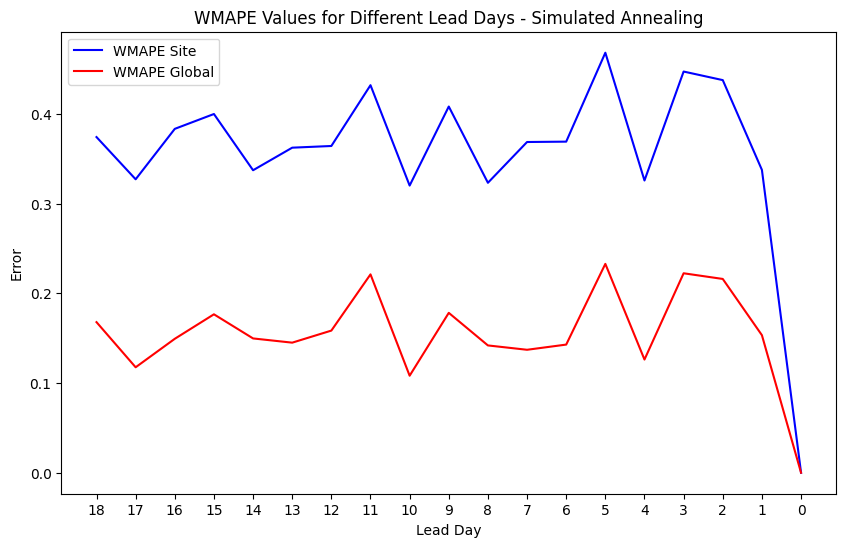

In [320]:
# Calculate WMAPE for all days
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days)
# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

In [369]:
def simulated_annealing_with_conditions(orders_df, target_orders_df, eligibility_dict, initial_day, target_day, previous_best_energy, initial_temp, final_temp, alpha, max_iter):
    current_allocation = orders_df['site'].values
    best_allocation = current_allocation.copy()
    current_energy = objective_function(current_allocation, orders_df, target_orders_df, initial_day, target_day)
    best_energy = current_energy

    temp = initial_temp
    step = 0

    # Perform initial simulated annealing with fixed steps if the current energy is higher
    while current_energy >= previous_best_energy and step < max_iter:
        new_allocation = generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict)
        new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        step += 1

        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}, Fixed Steps Phase')

    # Perform simulated annealing with temperature schedule if the energy is lower than previous best
    while temp > final_temp and step < max_iter:
        new_allocation = generate_multi_step_neighbor(current_allocation, orders_df, eligibility_dict)
        new_energy = objective_function(new_allocation, orders_df, target_orders_df, initial_day, target_day)

        if acceptance_probability(current_energy, new_energy, temp) > random.random():
            current_allocation = new_allocation
            current_energy = new_energy

            if current_energy < best_energy:
                best_allocation = current_allocation
                best_energy = current_energy

        improvement_rate = (current_energy - best_energy) / current_energy
        temp = adaptive_cooling_schedule(temp, alpha, improvement_rate)
        step += 1

        if step % 100 == 0:
            print(f'Step {step}: Best Energy {best_energy}, Temperature: {temp}')

    print(f'Final Step: {step}, Final Temperature: {temp}')
    return best_allocation, best_energy

In [370]:
def perform_simulated_annealing(lead_days, initial_temp, final_temp, alpha, max_iter, eligibility_dict):


    # Load the initial allocation dataframe for the first lead day
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{lead_days[0]}.csv')

    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{lead_days[0]}.csv', index=False)

    previous_best_energy = float('inf')

    for i in range(1, len(lead_days)):
        current_day = lead_days[i]
        previous_day = lead_days[i - 1]

        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')

        best_allocation, best_energy = simulated_annealing_with_conditions(
            current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day,
            previous_best_energy, initial_temp, final_temp, alpha, max_iter
        )

        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation

        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv', index=False)

        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()
        previous_best_energy = best_energy

In [ ]:
orders_dfs = {
        18: pd.read_csv(f'{allocation_dir}/allocation_lead_day_18.csv'),
        17: pd.read_csv(f'{allocation_dir}/allocation_lead_day_17.csv'),
        16: pd.read_csv(f'{allocation_dir}/allocation_lead_day_16.csv'),
        15: pd.read_csv(f'{allocation_dir}/allocation_lead_day_15.csv'),
        14: pd.read_csv(f'{allocation_dir}/allocation_lead_day_14.csv'),
        13: pd.read_csv(f'{allocation_dir}/allocation_lead_day_13.csv'),
        12: pd.read_csv(f'{allocation_dir}/allocation_lead_day_12.csv'),
        11: pd.read_csv(f'{allocation_dir}/allocation_lead_day_11.csv'),
        10: pd.read_csv(f'{allocation_dir}/allocation_lead_day_10.csv'),
        9: pd.read_csv(f'{allocation_dir}/allocation_lead_day_9.csv'),
        8: pd.read_csv(f'{allocation_dir}/allocation_lead_day_8.csv'),
        7: pd.read_csv(f'{allocation_dir}/allocation_lead_day_7.csv'),
        6: pd.read_csv(f'{allocation_dir}/allocation_lead_day_6.csv'),
        5: pd.read_csv(f'{allocation_dir}/allocation_lead_day_5.csv'),
        4: pd.read_csv(f'{allocation_dir}/allocation_lead_day_4.csv'),
        3: pd.read_csv(f'{allocation_dir}/allocation_lead_day_3.csv'),
        2: pd.read_csv(f'{allocation_dir}/allocation_lead_day_2.csv'),
        1: pd.read_csv(f'{allocation_dir}/allocation_lead_day_1.csv'),
        0: pd.read_csv(f'{allocation_dir}/allocation_lead_day_0.csv')
    }

lead_days = list(range(18, -1, -1))

# Perform simulated annealing
perform_simulated_annealing(lead_days, initial_temp=5000, final_temp=0.1, alpha=0.99, max_iter=20000, eligibility_dict=eligibility_dict)

# Calculate and plot WMAPE
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days)
# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

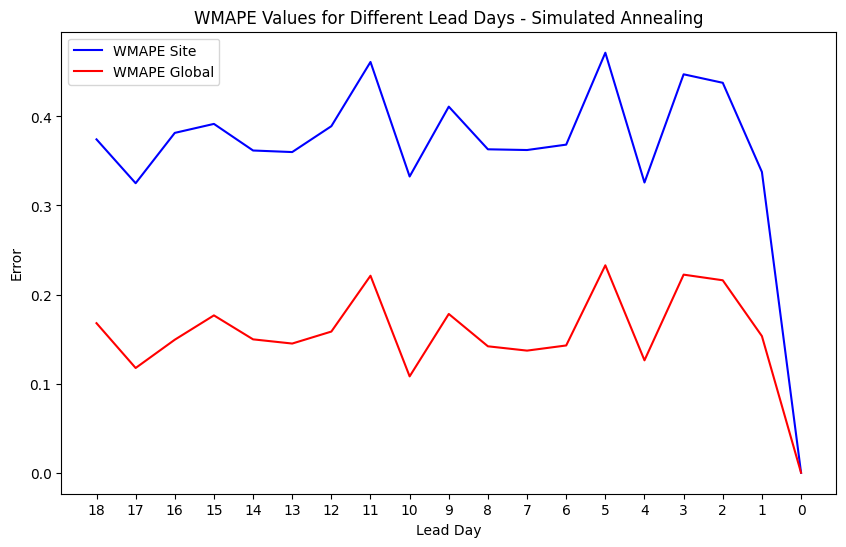

In [374]:
wmape_site_values, wmape_global_values = calculate_wmape_for_all_days(lead_days)
# Plot the WMAPE values
plot_wmape(lead_days, wmape_site_values, wmape_global_values)

In [377]:
def perform_simulated_annealing_specfic_days(pairs, initial_temp, final_temp, alpha, max_iter, eligibility_dict):

    # Load the initial allocation dataframe for the first lead day
    previous_day = pairs[0][1]
    previous_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{previous_day}.csv')

    # Ensure the first lead day stays unmodified
    previous_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{previous_day}.csv', index=False)

    previous_best_energy = float('inf')

    for current_day, previous_day in pairs:
        current_df = pd.read_csv(f'{allocation_dir}/allocation_lead_day_{current_day}.csv')

        best_allocation, best_energy = simulated_annealing_with_conditions(
            current_df.copy(), previous_df.copy(), eligibility_dict, current_day, previous_day,
            previous_best_energy, initial_temp, final_temp, alpha, max_iter
        )

        # Update the allocation for the current day with the best found allocation
        current_df['site'] = best_allocation

        # Save the updated dataframe for the current lead day
        current_df.to_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv', index=False)

        # Set the current dataframe as the previous dataframe for the next iteration
        previous_df = current_df.copy()
        previous_best_energy = best_energy

In [383]:
def calculate_and_plot_wmape(pairs):
    wmape_site_values = []
    wmape_global_values = []

    sa_allocation_dir = 'sa_allocations'  # Path to the directory containing the simulated annealing allocation files
    merged_allocation_dir = 'merged_allocations'  # Path to the directory to save the merged allocation files

    if not os.path.exists(merged_allocation_dir):
        os.makedirs(merged_allocation_dir)

    for current_day, previous_day in pairs:
        current_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{current_day}.csv')
        previous_df = pd.read_csv(f'{sa_allocation_dir}/sa_allocation_lead_day_{previous_day}.csv')

        aggregated_current_day = OrderMerger.aggregate_items(current_df, current_day)
        aggregated_previous_day = OrderMerger.aggregate_items(previous_df, previous_day)

        merged_df = OrderMerger.merge_allocation(aggregated_current_day, aggregated_previous_day, current_day, previous_day)

        _, wmape_site = WMAPE.calculate_wmape_site(merged_df, f'lead_{current_day}', f'lead_{previous_day}')
        _, wmape_global = WMAPE.calculate_wmape_global(merged_df, f'lead_{current_day}', f'lead_{previous_day}')

        wmape_site_values.append(wmape_site)
        wmape_global_values.append(wmape_global)

        # Save the merged dataframes
        merged_df.to_csv(f'{merged_allocation_dir}/merged_allocation_lead_day_{current_day}_to_{previous_day}.csv', index=False)

    lead_days_consecutive = [current_day for current_day, _ in pairs]

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(lead_days_consecutive, wmape_site_values, linestyle='-', color='b', label='WMAPE Site')
    ax.plot(lead_days_consecutive, wmape_global_values, linestyle='-', color='r', label='WMAPE Global')

    ax.set_xlabel('Lead Day')
    ax.set_ylabel('Error')
    ax.set_title('WMAPE Values for Selected Lead Days')
    ax.set_xticks(lead_days_consecutive)
    ax.legend()

    ax.invert_xaxis()

    plt.show()

In [ ]:
pairs = [(18, 10), (10, 5), (5, 0)]  # Example pairs, replace with actual pairs of lead days

# Perform simulated annealing
perform_simulated_annealing_specfic_days(pairs, initial_temp=5000, final_temp=0.1, alpha=0.99, max_iter=20000, eligibility_dict=eligibility_dict)

# Calculate and plot WMAPE
calculate_and_plot_wmape(pairs)